In [1]:
import requests
import gzip

url_train_images = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
url_train_labels = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

def download_and_extract(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, "wb") as f_out:
        f_out.write(gzip.decompress(response.content))
        
download_and_extract(url_train_images, "train-images-idx3-ubyte")
download_and_extract(url_train_labels, "train-labels-idx1-ubyte")

In [2]:
import numpy as np

def read_mnist_images(filename):
    with open(filename, "rb") as f:
        # Read magic number and number of images with big-endian format
        magic, num = np.frombuffer(f.read(8), dtype=">i4")
        if magic != 2051:
            raise ValueError("Invalid magic number")
        # Read image dimensions
        rows, cols = np.frombuffer(f.read(8), dtype=">i4")
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows * cols)
    return images

def read_mnist_labels(filename):
    with open(filename, "rb") as f:
        # Read magic number and number of labels with big-endian format
        magic, num = np.frombuffer(f.read(8), dtype=">i4")
        if magic != 2049:
            raise ValueError("Invalid magic number")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

images = read_mnist_images("train-images-idx3-ubyte")
labels = read_mnist_labels("train-labels-idx1-ubyte")

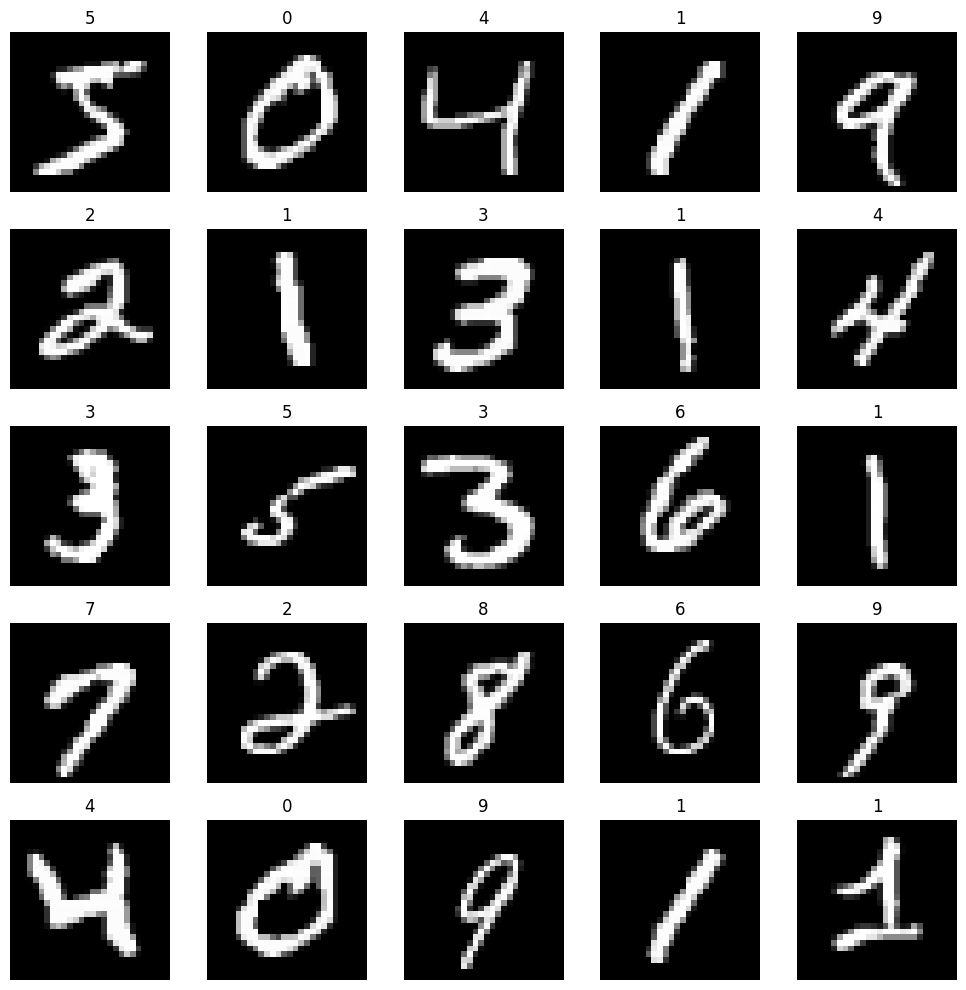

In [3]:
import matplotlib.pyplot as plt

def plot_samples(images, labels, num_rows=5, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')  # Hide axes
        ax.set_title(labels[i])

    plt.tight_layout()
    plt.show()

# Now, call the function to plot the samples
plot_samples(images, labels)

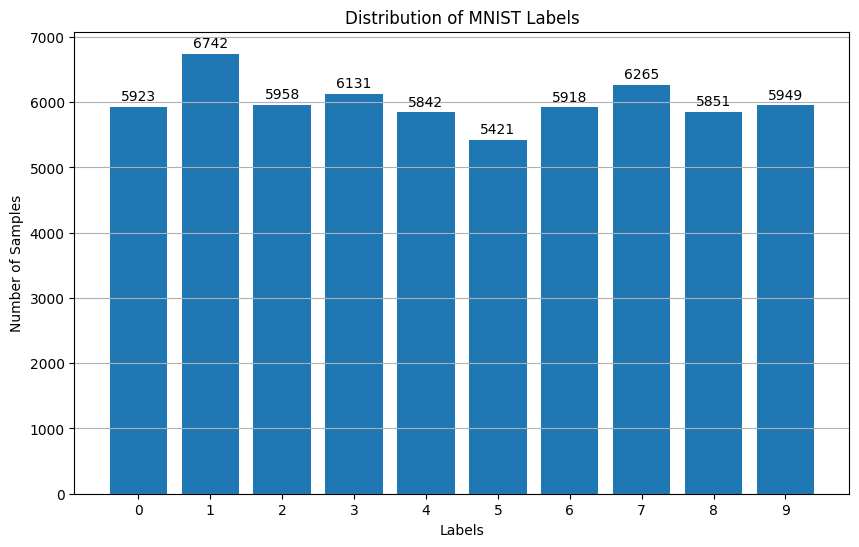

In [4]:
import matplotlib.pyplot as plt

def plot_label_distribution(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, tick_label=unique_labels)
    plt.xlabel('Labels')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of MNIST Labels')
    plt.grid(axis='y')

    # Display the count above each bar
    for i, count in enumerate(counts):
        plt.text(i, count + 100, str(count), ha='center')  # Adjust the +100 for better visualization if necessary

    plt.show()

plot_label_distribution(labels)

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize SparkSession with memory configurations
spark = SparkSession.builder \
    .appName("MNIST") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Convert numpy arrays to lists of Rows
data_tuples = list(zip(labels.tolist(), images.tolist()))
rows = [Row(label=l, features=features) for l, features in data_tuples]

# Create DataFrame
df = spark.createDataFrame(rows)

23/10/16 10:56:00 WARN Utils: Your hostname, HOUS-GF63-Thin-10SCSR resolves to a loopback address: 127.0.1.1; using 192.168.81.210 instead (on interface wlo1)
23/10/16 10:56:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/16 10:56:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
conf = spark.sparkContext.getConf()
all_settings = conf.getAll()
for k, v in all_settings:
    print(f"{k} = {v}")

spark.executor.extraJavaOptions = -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.name = MNIST
spark.driver.port = 41089
spark.driver.host = 192.168.81.210
spark.app.startTime = 1697450161215
spark.driver.memory = 4g
spark.executor.i

In [7]:
# Get the SparkContext's configuration
conf = spark.sparkContext.getConf()

# Extract memory configurations
executor_memory = conf.get("spark.executor.memory", "Not set")
driver_memory = conf.get("spark.driver.memory", "Not set")
executor_memory_overhead = conf.get("spark.executor.memoryOverhead", "Not set")
driver_memory_overhead = conf.get("spark.driver.memoryOverhead", "Not set")

# Print the memory configurations
print(f"Executor Memory: {executor_memory}")
print(f"Driver Memory: {driver_memory}")
print(f"Executor Memory Overhead: {executor_memory_overhead}")
print(f"Driver Memory Overhead: {driver_memory_overhead}")

Executor Memory: 8g
Driver Memory: 4g
Executor Memory Overhead: Not set
Driver Memory Overhead: Not set


In [8]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Define UDF to convert a list to a dense vector
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Apply the UDF to the 'features' column
df_vec = df.withColumn("features_vec", list_to_vector_udf(df["features"]))

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler

# Normalize the features to improve clustering performance
scaler = StandardScaler(inputCol="features_vec", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

# Initialize KMeans
kmeans = KMeans().setK(6).setFeaturesCol("scaledFeatures").setPredictionCol("cluster")

# Train the model
kmeans_model = kmeans.fit(df_scaled)

# Assign clusters to events
df_with_clusters = kmeans_model.transform(df_scaled)

# Show the result
df_with_clusters.select("label", "cluster").show()

# Evaluate clustering by computing Within Set Sum of Squared Errors
# Assuming you've already trained your KMeans model and named it 'kmeans_model'
wssse = kmeans_model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))

23/10/16 10:57:26 WARN TaskSetManager: Stage 0 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:57:37 WARN TaskSetManager: Stage 3 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:57:46 WARN TaskSetManager: Stage 6 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:01 WARN TaskSetManager: Stage 7 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:02 WARN TaskSetManager: Stage 8 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:02 WARN TaskSetManager: Stage 9 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:02 WARN TaskSetManager: Stage 10 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:

+-----+-------+
|label|cluster|
+-----+-------+
|    5|      0|
|    0|      0|
|    4|      1|
|    1|      2|
|    9|      3|
|    2|      0|
|    1|      2|
|    3|      0|
|    1|      2|
|    4|      3|
|    3|      2|
|    5|      2|
|    3|      4|
|    6|      1|
|    1|      2|
|    7|      3|
|    2|      1|
|    8|      0|
|    6|      1|
|    9|      2|
+-----+-------+
only showing top 20 rows

Within Set Sum of Squared Errors = 38336205.505703494


23/10/16 10:58:14 WARN TaskSetManager: Stage 57 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.


23/10/16 10:58:14 WARN TaskSetManager: Stage 58 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.


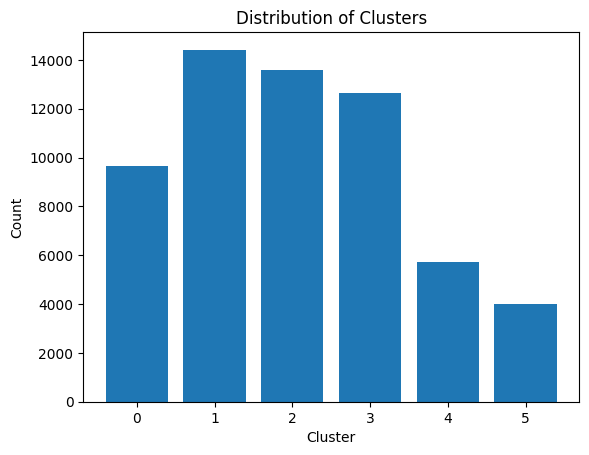

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_counts = df_with_clusters.groupBy("cluster").count().collect()
clusters = [row['cluster'] for row in cluster_counts]
counts = [row['count'] for row in cluster_counts]

plt.bar(clusters, counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()

In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_vec", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

costs = []
for k in range(4, 9):  # Example range
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    kmeans_model = kmeans.fit(df_scaled)
    cost = kmeans_model.summary.trainingCost  # Within Set Sum of Squared Errors
    costs.append(cost)

23/10/16 10:58:21 WARN TaskSetManager: Stage 61 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:29 WARN TaskSetManager: Stage 64 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:36 WARN TaskSetManager: Stage 67 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:51 WARN TaskSetManager: Stage 68 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:51 WARN TaskSetManager: Stage 69 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:52 WARN TaskSetManager: Stage 70 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 10:58:52 WARN TaskSetManager: Stage 71 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/

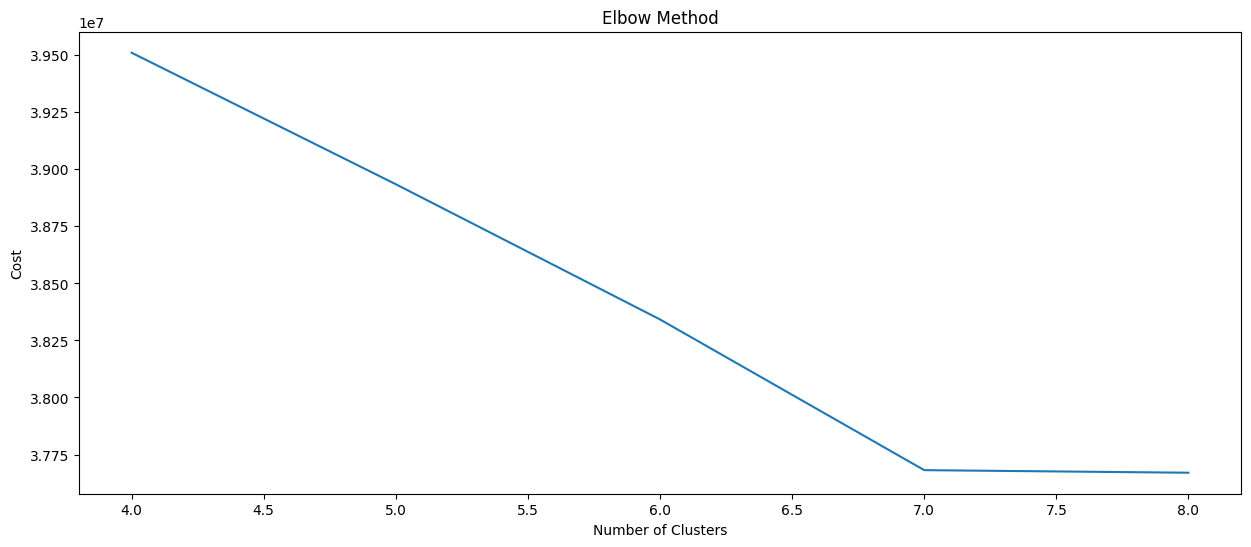

In [12]:
plt.figure(figsize=(15,6))
plt.plot(range(4, 9), costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method')
plt.show()

In [13]:
df_with_clusters.select("label", "cluster").show()

+-----+-------+
|label|cluster|
+-----+-------+
|    5|      0|
|    0|      0|
|    4|      1|
|    1|      2|
|    9|      3|
|    2|      0|
|    1|      2|
|    3|      0|
|    1|      2|
|    4|      3|
|    3|      2|
|    5|      2|
|    3|      4|
|    6|      1|
|    1|      2|
|    7|      3|
|    2|      1|
|    8|      0|
|    6|      1|
|    9|      2|
+-----+-------+
only showing top 20 rows



23/10/16 11:01:22 WARN TaskSetManager: Stage 334 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.


In [14]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Store expert models in a dictionary
expert_models = {}

for i in range(6):  # Assuming you have 6 clusters
    # Filter data for cluster i
    cluster_data = df_with_clusters.filter(df_with_clusters.cluster == i)
    
    # Split data into training and testing sets
    train, test = cluster_data.randomSplit([0.8, 0.2], seed=12345)
    
    # Check the number of unique labels in the train set
    unique_labels_train = train.select("label").distinct().count()
    
    # If only one unique label in the train set, continue to the next cluster
    if unique_labels_train == 1:
        print(f"Training set for cluster {i} contains only one unique class. No need to train a classifier.")
        continue
    
    # Initialize the Decision Tree classifier
    dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label")
    
    # Train the Decision Tree classifier on the training data of this cluster
    dt_model = dt.fit(train)
    
    # Store the trained model in the dictionary
    expert_models[i] = dt_model
    
    # Evaluate the model's performance on test data
    predictions = dt_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    print(f"Accuracy for Decision Tree expert on cluster {i}: {accuracy:.2f}")

23/10/16 11:01:22 WARN TaskSetManager: Stage 335 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:01:32 WARN TaskSetManager: Stage 341 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:01:41 WARN TaskSetManager: Stage 344 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:01:43 WARN TaskSetManager: Stage 345 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:01:52 WARN TaskSetManager: Stage 346 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:02:03 WARN TaskSetManager: Stage 348 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:02:11 WARN TaskSetManager: Stage 350 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for Decision Tree expert on cluster 0: 0.83


23/10/16 11:02:30 WARN TaskSetManager: Stage 366 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:02:40 WARN TaskSetManager: Stage 369 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:02:41 WARN TaskSetManager: Stage 370 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:02:50 WARN TaskSetManager: Stage 371 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:02:59 WARN TaskSetManager: Stage 373 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:03:09 WARN TaskSetManager: Stage 375 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:03:09 WARN TaskSetManager: Stage 377 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for Decision Tree expert on cluster 1: 0.75


23/10/16 11:03:21 WARN TaskSetManager: Stage 385 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:03:31 WARN TaskSetManager: Stage 391 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:03:41 WARN TaskSetManager: Stage 394 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:03:43 WARN TaskSetManager: Stage 395 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:03:52 WARN TaskSetManager: Stage 396 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:01 WARN TaskSetManager: Stage 398 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:10 WARN TaskSetManager: Stage 400 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for Decision Tree expert on cluster 2: 0.75


23/10/16 11:04:21 WARN TaskSetManager: Stage 410 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:29 WARN TaskSetManager: Stage 416 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:39 WARN TaskSetManager: Stage 419 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:40 WARN TaskSetManager: Stage 420 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:49 WARN TaskSetManager: Stage 421 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:04:59 WARN TaskSetManager: Stage 423 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:05:08 WARN TaskSetManager: Stage 425 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for Decision Tree expert on cluster 3: 0.87


23/10/16 11:05:18 WARN TaskSetManager: Stage 435 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:05:28 WARN TaskSetManager: Stage 441 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:05:37 WARN TaskSetManager: Stage 444 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:05:38 WARN TaskSetManager: Stage 445 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:05:47 WARN TaskSetManager: Stage 446 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:05:56 WARN TaskSetManager: Stage 448 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:05 WARN TaskSetManager: Stage 450 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for Decision Tree expert on cluster 4: 0.80


23/10/16 11:06:24 WARN TaskSetManager: Stage 466 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:33 WARN TaskSetManager: Stage 469 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:34 WARN TaskSetManager: Stage 470 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:42 WARN TaskSetManager: Stage 471 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:51 WARN TaskSetManager: Stage 473 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:59 WARN TaskSetManager: Stage 475 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:06:59 WARN TaskSetManager: Stage 477 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for Decision Tree expert on cluster 5: 0.93


## Extracting and Organizing Class Probabilities for MoE Framework

Within the Mixture of Experts (MoE) paradigm, each expert provides a prediction, often in the form of class probabilities. These predictions are aggregated later based on certain criteria to give the final output. The provided code showcases how these predictions (class probabilities) are fetched and structured for further processing.

### Step-by-step Explanation:

1. **Features and Labels Extraction**:
   - `features`: The array holds the scaled features from the DataFrame `df_with_clusters`.
   - `labels`: It contains the class labels corresponding to each data point.

2. **Initialization**:
   - For the MoE approach, a predictions array, `all_predictions`, is initialized to store class probabilities from all experts.
   - The array is initialized with zeros, assuming 10 class probabilities for each data point across 6 experts.

3. **Extracting Class Probabilities**:
   - Iterate over each expert.
   - If an expert exists for a particular cluster (`i`), use the expert's model to make predictions on the data.
   - The class probabilities are then fetched from these predictions and stored in the corresponding slot in the `all_predictions` array.
   - If no expert exists for a particular cluster, a message is printed, and the loop continues to the next expert.

By the end of this process, the `all_predictions` array holds the class probabilities predicted by each expert for every data point. This organized structure facilitates subsequent processes in the MoE framework, such as aggregation or weighing of predictions.

In [15]:
# Extract features and labels from the DataFrame
features = np.array(df_with_clusters.select("scaledFeatures").rdd.map(lambda row: row[0]).collect())
labels = np.array(df_with_clusters.select("label").rdd.map(lambda row: row[0]).collect())

# For the MoE approach, initialize the predictions array with zeros for all experts
num_data_points = df_with_clusters.count()
all_predictions = np.zeros((6, num_data_points, 10))  # Assuming 10 class probabilities

for i in range(6):  # For each expert
    if i in expert_models:  # Check if the expert exists for the current cluster
        dt_model = expert_models[i]
        predictions = dt_model.transform(df_with_clusters)
        
        # Extract class probabilities from the predictions
        probabilities = np.array(predictions.select("probability").rdd.map(lambda row: row[0].toArray()).collect())
        all_predictions[i] = probabilities
    else:
        print(f"No expert for cluster {i}. Skipping...")

# At this point, all_predictions is already a NumPy array with the correct shape

23/10/16 11:07:09 WARN TaskSetManager: Stage 485 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:07:25 WARN TaskSetManager: Stage 486 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:07:27 WARN TaskSetManager: Stage 487 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:07:30 WARN TaskSetManager: Stage 490 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:07:41 WARN TaskSetManager: Stage 491 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:07:50 WARN TaskSetManager: Stage 492 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:07:58 WARN TaskSetManager: Stage 493 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

In [16]:
# Extract features and labels from the DataFrame
features = np.array(df_with_clusters.select("scaledFeatures").rdd.map(lambda row: row[0]).collect())
labels = np.array(df_with_clusters.select("label").rdd.map(lambda row: row[0]).collect())

# For the MoE approach, initialize the predictions array with zeros for all experts
num_data_points = df_with_clusters.count()
num_classes = 10
default_probabilities = np.full((num_data_points, num_classes), 1/num_classes)  # Equally distribute the probability for each class

all_predictions = np.zeros((6, num_data_points, num_classes))

for i in range(6):  # For each expert
    if i in expert_models:  # Check if the expert exists for the current cluster
        dt_model = expert_models[i]
        predictions = dt_model.transform(df_with_clusters)
        
        # Extract class probabilities from the predictions
        probabilities = np.array(predictions.select("probability").rdd.map(lambda row: row[0].toArray()).collect())
        all_predictions[i] = probabilities
    else:
        print(f"No expert for cluster {i}. Setting default probabilities...")
        all_predictions[i] = default_probabilities

# At this point, all_predictions is already a NumPy array with the correct shape

23/10/16 11:08:27 WARN TaskSetManager: Stage 496 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:08:41 WARN TaskSetManager: Stage 497 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:08:43 WARN TaskSetManager: Stage 498 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:08:45 WARN TaskSetManager: Stage 501 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:08:54 WARN TaskSetManager: Stage 502 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:09:03 WARN TaskSetManager: Stage 503 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:09:11 WARN TaskSetManager: Stage 504 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

In [17]:
import tensorflow as tf
from tensorflow import keras

gating_network = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')  # This should match the number of experts
])

2023-10-16 11:09:38.013689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 11:09:38.970631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-16 11:09:41.185310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-16 11:09:41.247342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [18]:
class MixtureOfExperts(keras.Model):
    def __init__(self, gating_network, num_experts, num_classes=10):
        super(MixtureOfExperts, self).__init__()
        self.gating_network = gating_network
        self.num_experts = num_experts
        self.num_classes = num_classes

    def call(self, inputs, expert_predictions):
        # Get gating weights
        weights = self.gating_network(inputs)

        # Use pre-computed expert predictions
        moe_pred = tf.reduce_sum(
            [weights[:, i:i+1] * expert_predictions[i] for i in range(self.num_experts)], axis=0
        )
        return moe_pred

In [19]:
moe = MixtureOfExperts(gating_network, num_experts=6, num_classes=10)

## Mixture of Experts (MoE) Loss Function

The MoE loss function has two main components:

1. **Classification Loss**:
This measures how well the predictions of the MoE model match the actual labels. It's given by:

$$
\text{classification\_loss} = - \sum_{i=1}^{C} y_{i} \log(\hat{y}_{i})
$$

Where:
- y_{i}  is the true probability of the sample belonging to class \( i \) (typically 0 or 1 for hard labels).
-  hat{y}_{i}  is the predicted probability of the sample belonging to class \( i \).
- C  is the number of classes.

2. **Gating Loss (Entropy Regularization)**:
This encourages the gating network to have a uniform distribution over the experts, ensuring no single expert is overly trusted for all data points. It's given by:

$$
\text{gating\_loss} = - \sum_{j=1}^{E} w_{j} \log(w_{j})
$$

Where:
- w_{j}  is the weight assigned by the gating network to the expert \( j \).
-  E  is the number of experts.

The combined loss is:

$$
\text{moe\_loss} = \text{classification\_loss} + \lambda \times \text{gating\_loss}
$$

Where lambda is a hyperparameter determining the importance of the gating loss relative to the classification loss.

In [20]:
def moe_loss(y_true, y_pred, inputs):
    # Classification loss
    classification_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # Gating loss (entropy regularization)
    weights = gating_network(inputs)  # Here, use the original image features
    gating_loss = -tf.reduce_mean(tf.reduce_sum(weights * tf.math.log(weights + 1e-10), axis=1))
    
    lambda_reg = 0.1  # hyperparameter for gating loss importance
    return classification_loss + lambda_reg * gating_loss

In [21]:
optimizer = tf.keras.optimizers.Adam()

# Convert the features, labels, and expert predictions to TensorFlow tensors
features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)  # Assuming labels are integers
all_predictions_tensor = tf.convert_to_tensor(all_predictions, dtype=tf.float32)

# Convert labels to one-hot encoded format (assuming there are 10 classes)
labels_tensor_onehot = tf.one_hot(labels_tensor, depth=10)

# Train the MoE model
epochs = 10
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = moe(features_tensor, all_predictions_tensor)
        # Compute the loss value
        loss_value = moe_loss(labels_tensor_onehot, predictions, features_tensor)

        # Get gradients
        gradients = tape.gradient(loss_value, moe.trainable_variables)
        
        # Update weights
        optimizer.apply_gradients(zip(gradients, moe.trainable_variables))

    # Print loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_value.numpy()}")

2023-10-16 11:09:42.865882: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5eb12a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 11:09:42.865917: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti with Max-Q Design, Compute Capability 7.5
2023-10-16 11:09:42.870926: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 11:09:44.065925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-10-16 11:09:44.144936: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 11:09:44.197988: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/10 - Loss: [1.7945256  0.89629793 0.59311295 ... 1.0749346  0.7582885  1.0267018 ]
Epoch 2/10 - Loss: [1.3494089  0.60753894 0.39196938 ... 1.008458   0.26749563 0.967503  ]
Epoch 3/10 - Loss: [1.1992065  0.4955265  0.21399173 ... 0.87190855 0.25899816 1.0449774 ]
Epoch 4/10 - Loss: [0.9748813  0.37723747 0.1357515  ... 0.7618974  0.22481918 1.2879606 ]
Epoch 5/10 - Loss: [0.7218314  0.20575094 0.1088471  ... 0.69357604 0.1562086  1.2954714 ]
Epoch 6/10 - Loss: [0.32843167 0.12283808 0.09728296 ... 0.5504581  0.10751089 0.952507  ]
Epoch 7/10 - Loss: [0.14990991 0.09437016 0.09050158 ... 0.32662374 0.07417852 0.58064026]
Epoch 8/10 - Loss: [0.11757319 0.07984401 0.08130929 ... 0.2079913  0.05750753 0.42589837]
Epoch 9/10 - Loss: [0.10680883 0.06921203 0.06467164 ... 0.1787394  0.05426981 0.41799268]
Epoch 10/10 - Loss: [0.09978142 0.06194051 0.05560566 ... 0.17764483 0.05490583 0.4695466 ]


### Mixture of Experts Prediction Formula:

For each data point, the prediction from the Mixture of Experts model, denoted as moe_pred, is calculated as:

$$
\text{moe\_pred} = \sum_{j=1}^{E} w_j \times \text{expert\_predictions}_j
$$

Where:
- w_j: Represents the weight assigned by the gating network to the expert \( j \).
- expert\_predictions_j : Denotes the prediction vector (over classes) from expert \( j \).
- E : Is the total number of experts in the model.


In [22]:
def predict_moe(df, gating_network, expert_models):
    """
    Make predictions using the Mixture of Experts model.

    Arguments:
    - df: The input samples as a PySpark DataFrame.
    - gating_network: The trained gating network model.
    - expert_models: A dictionary of trained expert models with expert number as key.

    Returns:
    - moe_predictions: The combined predictions from the MoE model.
    """

    # Convert DataFrame to a NumPy array for the gating network
    inputs_np = np.array(df.rdd.map(lambda row: row[0]).collect())
    inputs_tf = tf.convert_to_tensor(inputs_np, dtype=tf.float32)

    # Get the gating weights for the input
    gating_weights = gating_network(inputs_tf).numpy()

    # Predict using each expert and weight the predictions using the gating weights
    moe_predictions = np.zeros((inputs_np.shape[0], 10))  # Assuming there are 10 classes
    
    for i, expert_model in expert_models.items():
        if i == 4:  # Skip the expert for cluster 4
            continue
        expert_preds = expert_model.transform(df)
        probs = np.array(expert_preds.select("probability").rdd.map(lambda row: row[0].toArray()).collect())
        moe_predictions += gating_weights[:, i][:, np.newaxis] * probs

    return moe_predictions

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Extract labels from the DataFrame into a NumPy array
labels_array = np.array(test.select("label").rdd.map(lambda row: row[0]).collect())

sample_inputs_df = test.select("scaledFeatures")

# Get predictions using the MoE model
moe_preds = predict_moe(sample_inputs_df, gating_network, expert_models)

# Convert the combined MoE predictions to class labels
predicted_class_labels = np.argmax(moe_preds, axis=1)

# Compute Metrics
accuracy = accuracy_score(labels_array, predicted_class_labels)
f1 = f1_score(labels_array, predicted_class_labels, average='weighted')
precision = precision_score(labels_array, predicted_class_labels, average='weighted')
recall = recall_score(labels_array, predicted_class_labels, average='weighted')
conf_matrix = confusion_matrix(labels_array, predicted_class_labels)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")

23/10/16 11:09:47 WARN TaskSetManager: Stage 507 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:09:55 WARN TaskSetManager: Stage 508 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:10:04 WARN TaskSetManager: Stage 509 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:10:13 WARN TaskSetManager: Stage 510 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:10:22 WARN TaskSetManager: Stage 511 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:10:31 WARN TaskSetManager: Stage 512 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:10:43 WARN TaskSetManager: Stage 513 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy: 0.9469
F1 Score: 0.9451
Precision: 0.9455
Recall: 0.9469
Confusion Matrix: 
[[655   1   0   0   0   2   1   1   5]
 [  2   6   0   1   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0]
 [  1   0   0   4   0   1   0   0   2]
 [  3   0   1   0   3   0   0   0   0]
 [  4   0   1   1   0  83   0   0   1]
 [  4   0   0   0   1   0   5   0   0]
 [  2   1   0   0   0   0   0   3   0]
 [  5   0   0   0   0   0   1   1   6]]


In [24]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Store expert models in a dictionary
expert_models = {}

for i in range(6):  # Assuming you have 6 clusters
    # Filter data for cluster i
    cluster_data = df_with_clusters.filter(df_with_clusters.cluster == i)
    
    # Split data into training and testing sets
    train, test = cluster_data.randomSplit([0.8, 0.2], seed=12345)
    
    # Check the number of unique labels in the train set
    unique_labels_train = train.select("label").distinct().count()
    
    # If only one unique label in the train set, continue to the next cluster
    if unique_labels_train == 1:
        print(f"Training set for cluster {i} contains only one unique class. No need to train a classifier.")
        continue
    
    # Initialize the RandomForest classifier
    rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=100)

    # Train the RandomForest classifier on the training data of this cluster
    rf_model = rf.fit(train)

    # Store the trained model in the dictionary
    expert_models[i] = rf_model

    # Evaluate the model's performance on test data
    predictions = rf_model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    print(f"Accuracy for RandomForest expert on cluster {i}: {accuracy:.2f}")

23/10/16 11:10:54 WARN TaskSetManager: Stage 514 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:11:06 WARN TaskSetManager: Stage 520 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:11:17 WARN TaskSetManager: Stage 523 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:11:19 WARN TaskSetManager: Stage 524 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:11:30 WARN TaskSetManager: Stage 525 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:11:42 WARN TaskSetManager: Stage 527 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:11:53 WARN TaskSetManager: Stage 529 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for RandomForest expert on cluster 0: 0.89


23/10/16 11:12:21 WARN TaskSetManager: Stage 545 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:12:33 WARN TaskSetManager: Stage 548 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:12:35 WARN TaskSetManager: Stage 549 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:12:46 WARN TaskSetManager: Stage 550 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:12:58 WARN TaskSetManager: Stage 552 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:13:10 WARN TaskSetManager: Stage 554 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:13:11 WARN TaskSetManager: Stage 556 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for RandomForest expert on cluster 1: 0.85


23/10/16 11:13:38 WARN TaskSetManager: Stage 570 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:13:49 WARN TaskSetManager: Stage 573 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:13:50 WARN TaskSetManager: Stage 574 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:14:02 WARN TaskSetManager: Stage 575 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:14:13 WARN TaskSetManager: Stage 577 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:14:24 WARN TaskSetManager: Stage 579 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:14:25 WARN TaskSetManager: Stage 581 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for RandomForest expert on cluster 2: 0.85


23/10/16 11:14:39 WARN TaskSetManager: Stage 589 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:14:50 WARN TaskSetManager: Stage 595 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:15:01 WARN TaskSetManager: Stage 598 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:15:02 WARN TaskSetManager: Stage 599 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:15:14 WARN TaskSetManager: Stage 600 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:15:25 WARN TaskSetManager: Stage 602 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:15:37 WARN TaskSetManager: Stage 604 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for RandomForest expert on cluster 3: 0.87


23/10/16 11:16:02 WARN TaskSetManager: Stage 620 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:16:12 WARN TaskSetManager: Stage 623 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:16:14 WARN TaskSetManager: Stage 624 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:16:24 WARN TaskSetManager: Stage 625 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:16:34 WARN TaskSetManager: Stage 627 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:16:45 WARN TaskSetManager: Stage 629 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:16:45 WARN TaskSetManager: Stage 631 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for RandomForest expert on cluster 4: 0.87


23/10/16 11:17:09 WARN TaskSetManager: Stage 645 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:17:19 WARN TaskSetManager: Stage 648 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:17:21 WARN TaskSetManager: Stage 649 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:17:31 WARN TaskSetManager: Stage 650 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:17:41 WARN TaskSetManager: Stage 652 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:17:51 WARN TaskSetManager: Stage 654 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:17:52 WARN TaskSetManager: Stage 656 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.

Accuracy for RandomForest expert on cluster 5: 0.94


In [25]:
# Extract features and labels from the DataFrame
features = np.array(df_with_clusters.select("scaledFeatures").rdd.map(lambda row: row[0]).collect())
labels = np.array(df_with_clusters.select("label").rdd.map(lambda row: row[0]).collect())

# For the MoE approach, initialize the predictions array with zeros for all experts
num_data_points = df_with_clusters.count()
all_predictions = np.zeros((6, num_data_points, 10))  # Assuming 10 class probabilities

for i in range(6):  # For each expert
    if i in expert_models:  # Check if the expert exists for the current cluster
        dt_model = expert_models[i]
        predictions = dt_model.transform(df_with_clusters)
        
        # Extract class probabilities from the predictions
        probabilities = np.array(predictions.select("probability").rdd.map(lambda row: row[0].toArray()).collect())
        all_predictions[i] = probabilities
    else:
        print(f"No expert for cluster {i}. Skipping...")

# At this point, all_predictions is already a NumPy array with the correct shape

23/10/16 11:18:04 WARN TaskSetManager: Stage 664 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:18:18 WARN TaskSetManager: Stage 665 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:18:21 WARN TaskSetManager: Stage 666 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1036.0 KiB
23/10/16 11:18:23 WARN TaskSetManager: Stage 669 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB
23/10/16 11:18:34 WARN TaskSetManager: Stage 670 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1053.6 KiB
23/10/16 11:18:44 

In [26]:
optimizer = tf.keras.optimizers.Adam()

# Convert the features, labels, and expert predictions to TensorFlow tensors
features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)  # Assuming labels are integers
all_predictions_tensor = tf.convert_to_tensor(all_predictions, dtype=tf.float32)

# Convert labels to one-hot encoded format (assuming there are 10 classes)
labels_tensor_onehot = tf.one_hot(labels_tensor, depth=10)

# Train the MoE model
epochs = 10
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = moe(features_tensor, all_predictions_tensor)
        # Compute the loss value
        loss_value = moe_loss(labels_tensor_onehot, predictions, features_tensor)

        # Get gradients
        gradients = tape.gradient(loss_value, moe.trainable_variables)
        
        # Update weights
        optimizer.apply_gradients(zip(gradients, moe.trainable_variables))

    # Print loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_value.numpy()}")

Epoch 1/10 - Loss: [0.3554074  0.05274805 0.27253807 ... 0.35786146 0.5333797  0.8202039 ]
Epoch 2/10 - Loss: [0.34544468 0.11985839 0.25691986 ... 0.25483292 0.82162684 0.6223213 ]
Epoch 3/10 - Loss: [0.34829313 0.04185771 0.2587832  ... 0.31051764 0.4351759  0.6879095 ]
Epoch 4/10 - Loss: [0.3503792  0.04259305 0.25965163 ... 0.26999152 0.41947228 0.8107274 ]
Epoch 5/10 - Loss: [0.34941578 0.04228343 0.25948495 ... 0.26259467 0.46287638 0.8138742 ]
Epoch 6/10 - Loss: [0.347596   0.04130299 0.25974017 ... 0.25908744 0.46359533 0.70657295]
Epoch 7/10 - Loss: [0.34540713 0.03966151 0.2569097  ... 0.2551317  0.46164292 0.64151865]
Epoch 8/10 - Loss: [0.3430329  0.03843839 0.25400397 ... 0.25240007 0.45931178 0.622544  ]
Epoch 9/10 - Loss: [0.3410224  0.03767323 0.2519534  ... 0.25036436 0.457325   0.6173634 ]
Epoch 10/10 - Loss: [0.33957106 0.03529307 0.25060374 ... 0.24864414 0.4558341  0.6151567 ]


In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Extract labels from the DataFrame into a NumPy array
labels_array = np.array(test.select("label").rdd.map(lambda row: row[0]).collect())

sample_inputs_df = test.select("scaledFeatures")

# Get predictions using the MoE model
moe_preds = predict_moe(sample_inputs_df, gating_network, expert_models)

# Convert the combined MoE predictions to class labels
predicted_class_labels = np.argmax(moe_preds, axis=1)

# Compute Metrics
accuracy = accuracy_score(labels_array, predicted_class_labels)
f1 = f1_score(labels_array, predicted_class_labels, average='weighted')
precision = precision_score(labels_array, predicted_class_labels, average='weighted')
recall = recall_score(labels_array, predicted_class_labels, average='weighted')
conf_matrix = confusion_matrix(labels_array, predicted_class_labels)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")

23/10/16 11:19:28 WARN TaskSetManager: Stage 675 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:19:37 WARN TaskSetManager: Stage 676 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:19:47 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
23/10/16 11:19:47 WARN TaskSetManager: Stage 677 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
23/10/16 11:19:56 WARN TaskSetManager: Stage 678 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:20:06 WARN DAGScheduler: Broadcasting large task binary with size 1135.0 KiB
23/10/16 11:20:06 WARN TaskSetManager: Stage 679 contains a task of very large size (6312 KiB). The maximum recommended task size is 1000 KiB.
23/10/16 11:20:16 

Accuracy: 0.9605
F1 Score: 0.9576
Precision: 0.9604
Recall: 0.9605
Confusion Matrix: 
[[662   0   0   0   1   1   0   1   0]
 [  0   9   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0]
 [  1   0   0   5   0   1   0   0   1]
 [  3   0   1   0   3   0   0   0   0]
 [  4   2   0   0   0  84   0   0   0]
 [  5   0   0   1   0   0   4   0   0]
 [  0   0   3   0   0   0   0   3   0]
 [  4   1   0   0   0   0   2   0   6]]
